# Introduction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [12]:
SEED = 42
np.random.seed(SEED)

# Load Data

In [2]:
# Data folder path
data_dir = Path().parent / "data"
data_dir.mkdir(exist_ok=True)

In [3]:
# Read data files
target_col = 'Listening_Time_minutes'

train = pd.read_csv(data_dir / 'train.csv')
X, y = train.drop(columns=[target_col]), train[target_col]

test = pd.read_csv(data_dir / 'test.csv')
sample_submission = pd.read_csv(data_dir / 'sample_submission.csv')

In [8]:
X.shape

(750000, 11)

In [9]:
for col in X.columns:
    missing_values = X[col].isna().sum()
    if missing_values > 0:
        # Print the number of missing values
        print(f"Column: {col} has {missing_values} missing values")

Column: Episode_Length_minutes has 87093 missing values
Column: Guest_Popularity_percentage has 146030 missing values
Column: Number_of_Ads has 1 missing values


# EDA

## Train Test Split

In [32]:
from sklearn.model_selection import train_test_split

RATIO = 0.2

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=RATIO, 
    stratify=train[target_col],
    random_state=SEED)


## Target Distribution

----------------------------------------
Stats:
----------------------------------------
Train Mean: 45.43906178961666
Train Std: 27.13859359937977
----------------------------------------
Validation Mean: 45.4307842822
Validation Std: 27.137244161427407


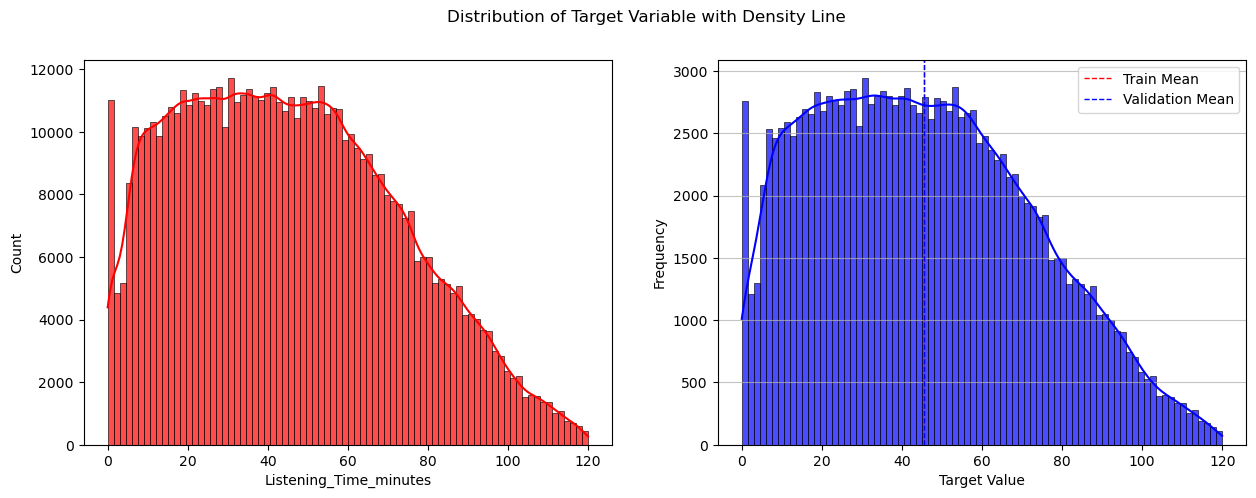

In [33]:
# Simple plotting of the target variable

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(y_train, bins=80, kde=True, color='red', alpha=0.7, ax=ax[0])
plt.axvline(y_train.mean(), color='red', linestyle='dashed', linewidth=1, label='Train Mean')

# Quick peak at the validation set
sns.histplot(y_val, bins=80, kde=True, color='blue', alpha=0.7, ax=ax[1])
plt.axvline(y_val.mean(), color='blue', linestyle='dashed', linewidth=1, label='Validation Mean')

fig.suptitle('Distribution of Target Variable with Density Line')

plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.legend()


print("--"*20)
print(f"Stats:")
print("--"*20)
print(f"Train Mean: {y_train.mean()}")
print(f"Train Std: {y_train.std()}")
print("--"*20)
print(f"Validation Mean: {y_val.mean()}")
print(f"Validation Std: {y_val.std()}")

## Mean Target value vs features

Exploring correlation between target value and the rest of the columns

In [19]:
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

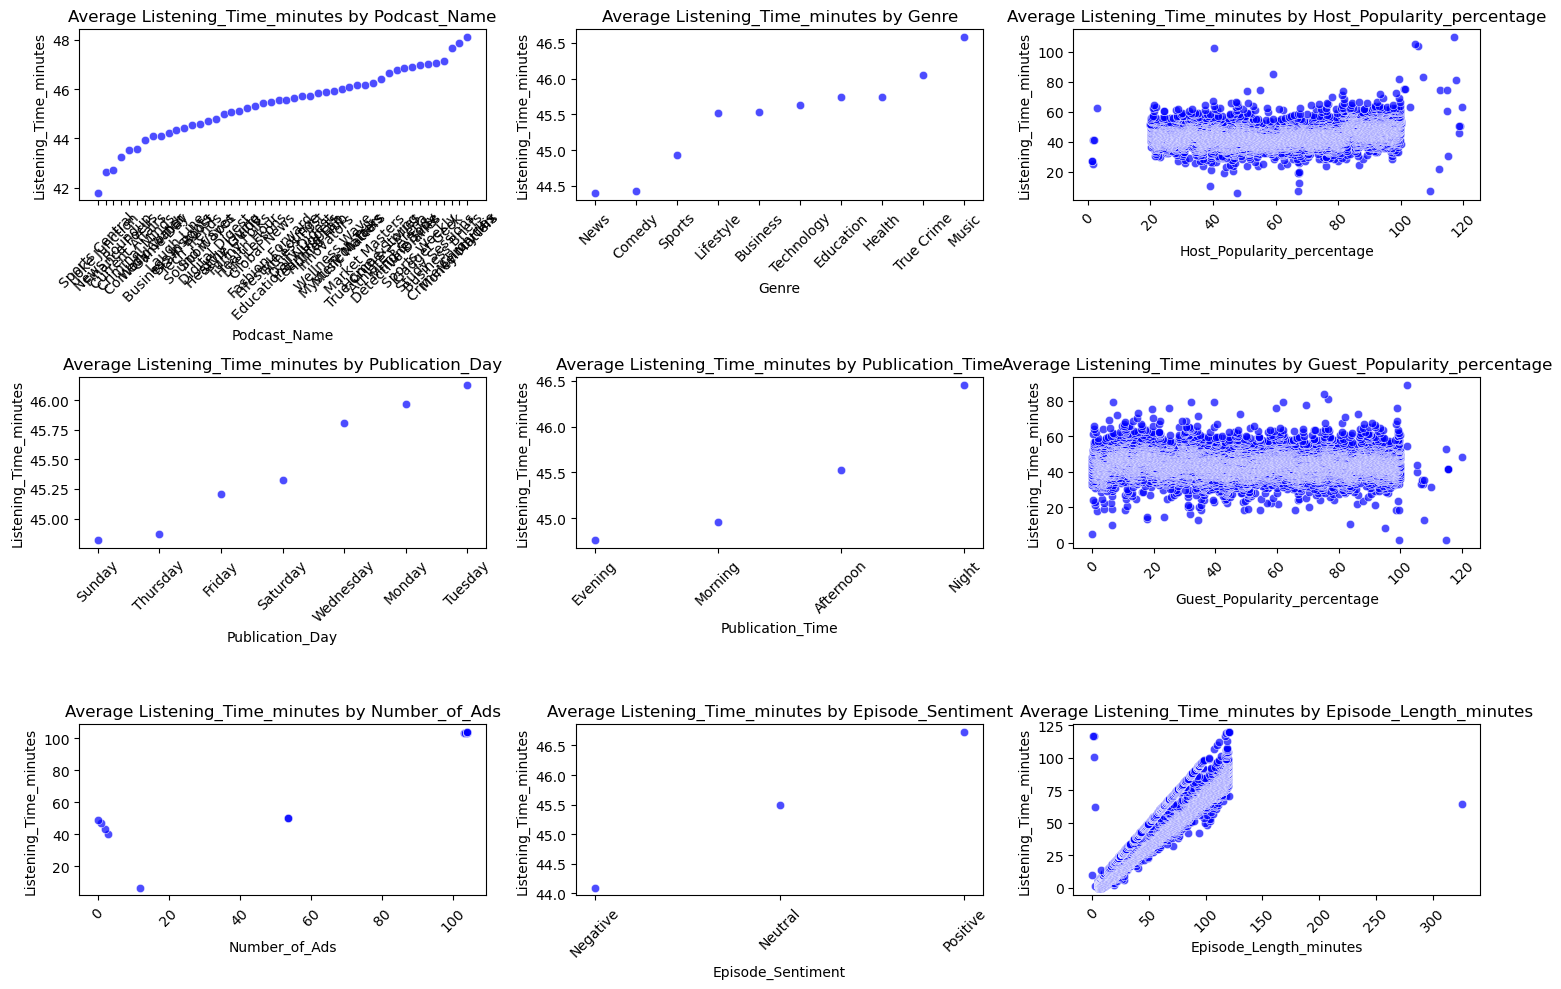

In [20]:
avg_target_per_category = ['Podcast_Name', 'Genre', 'Host_Popularity_percentage', 'Publication_Day', 'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Episode_Sentiment', 'Episode_Length_minutes']

# Plot average target value per category
plt.figure(figsize=(15, 10))
for i, col in enumerate(avg_target_per_category):
    grouped = train.groupby(col)[target_col].mean().sort_values().reset_index()
    plt.subplot(3, 3, i + 1)
    sns.scatterplot(data=grouped, x=col, y=target_col, color='blue', alpha=0.7)
    plt.title(f'Average {target_col} by {col}')
    plt.xlabel(col)
    plt.ylabel(target_col)
    plt.xticks(rotation=45)
    plt.tight_layout()

## Features Distribution

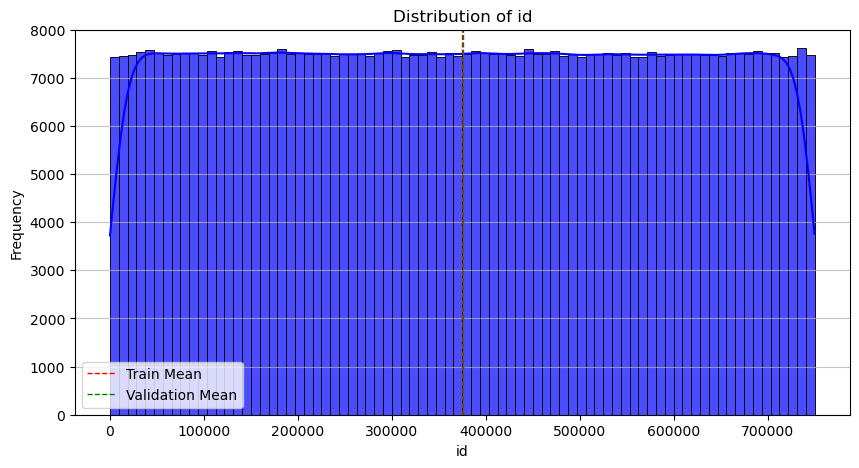

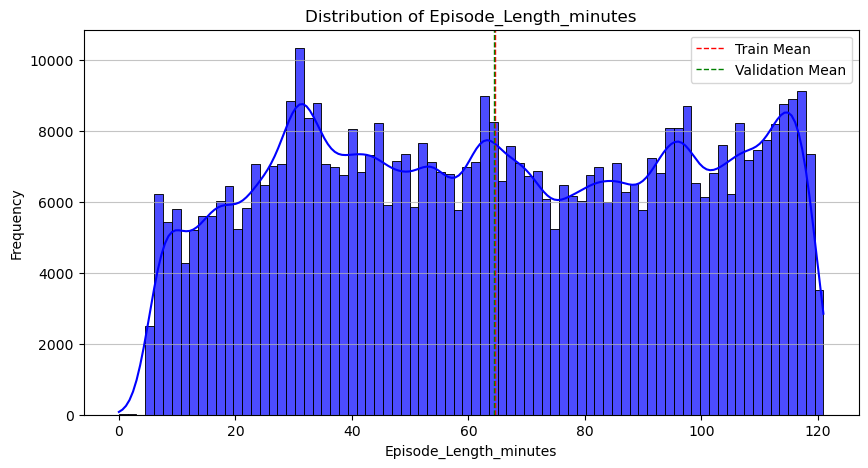

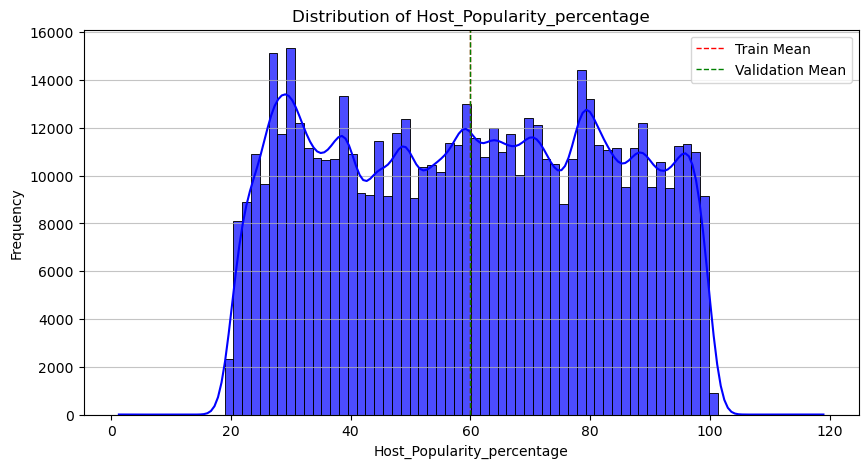

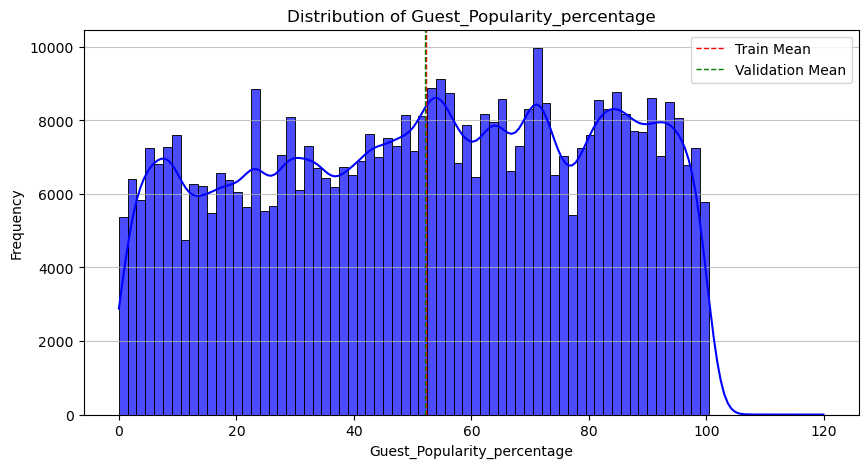

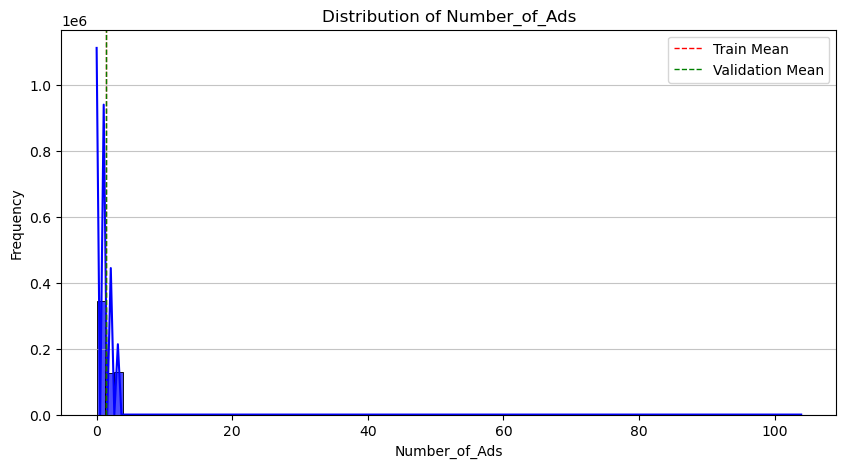

In [37]:
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

for col in numerical_cols:
    plt.figure(figsize=(10, 5))
    sns.histplot(X_train[col], bins=80, kde=True, color='blue', alpha=0.7)
    plt.axvline(X_train[col].mean(), color='red', linestyle='dashed', linewidth=1, label='Train Mean')
    plt.axvline(X_val[col].mean(), color='green', linestyle='dashed', linewidth=1, label='Validation Mean')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.legend()
    plt.show()

# Preprocessing

## Feature Engineering

In [21]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [25]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,600000.0,374887.268260,216495.270700,0.0,187275.50,374830.50,562336.25,749999.00
Episode_Length_minutes,530219.0,64.532632,32.974648,0.0,35.77,63.87,94.09,120.93
Host_Popularity_percentage,600000.0,59.859155,22.870738,1.3,39.43,60.06,79.53,118.93
Guest_Popularity_percentage,483260.0,52.267251,28.446701,0.0,28.43,53.62,76.64,119.91
Number_of_Ads,599999.0,1.348430,1.161173,0.0,0.00,1.00,2.00,103.91


In [23]:
X_train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
473369,473369,World Watch,Episode 41,32.29,News,62.95,Thursday,Afternoon,40.83,2.0,Positive
207987,207987,Crime Chronicles,Episode 24,111.03,True Crime,52.71,Tuesday,Morning,81.59,1.0,Negative
126595,126595,Style Guide,Episode 25,93.55,Lifestyle,67.35,Tuesday,Night,NaN,3.0,Neutral
519973,519973,Global News,Episode 92,62.74,News,92.13,Friday,Night,41.07,2.0,Negative
78405,78405,Money Matters,Episode 79,46.35,Business,39.05,Wednesday,Night,6.42,0.0,Positive


In [22]:
X_train.columns

Index(['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
       'Genre', 'Host_Popularity_percentage', 'Publication_Day',
       'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
       'Episode_Sentiment'],
      dtype='object')

In [ ]:
def feature_eng(df):
    # Get episode number from the title (Episode 37 -> 37)
    df['Episode_Number'] = df['Episode_Title'].replace('Episode ', '').astype(int)

    df['Ad_denisty'] = df['Number_of_Ads'] / df['Episode_Length_minutes']

